In [23]:
from pymongo import MongoClient
import random
import string
import psutil
import time
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from scipy.stats import mannwhitneyu
import memory_profiler
#brew services start mongodb-community@6.0


In [24]:
# Connect to MongoDB (default host and port: localhost:27017)
client = MongoClient('mongodb://localhost:27017/')
# Create or access the 'user_info_db' database
db = client['user_info_db']

In [25]:
collection_50 = db['user_info_50']
collection_500 = db['user_info_500']
collection_5000 = db['user_info_5000']

classical_search_50 = db['classical_search_50']
classical_search_500 = db['classical_search_500']
classical_search_5000 = db['classical_search_5000']

In [26]:
def generate_random_name(length=6):
    """Generate a random name of a specified length"""
    return ''.join(random.choices(string.ascii_uppercase, k=length))

In [27]:
# Insertion function for 'user_info_50'
def insert_user_info_50():
    collection_50.delete_many({})  # Clear any existing data
    names_50 = [{"name": generate_random_name()} for _ in range(50)]
    collection_50.insert_many(names_50)
    print("Inserted 50 names into user_info_50.")

# Insertion function for 'user_info_500'
def insert_user_info_500():
    collection_500.delete_many({})  # Clear any existing data
    names_500 = [{"name": generate_random_name()} for _ in range(500)]
    collection_500.insert_many(names_500)
    print("Inserted 500 names into user_info_500.")

# Insertion function for 'user_info_5000'
def insert_user_info_5000():
    collection_5000.delete_many({})  # Clear any existing data
    names_5000 = [{"name": generate_random_name()} for _ in range(5000)]
    collection_5000.insert_many(names_5000)
    print("Inserted 5000 names into user_info_5000.")

# inserting
insert_user_info_50()
insert_user_info_500()
insert_user_info_5000()


Inserted 50 names into user_info_50.
Inserted 500 names into user_info_500.
Inserted 5000 names into user_info_5000.


In [28]:
# Step 2: Create the target name lists
# Helper function to create target lists (existing + non-existing names)
def create_target_name_list(collection_name, total_names):
    collection = db[collection_name]
    existing_names = [user["name"] for user in collection.find()]
    print(f"Existing names in {collection_name}: {existing_names[:10]}")  # Displaying first 10 names for inspection
    
    # Generate non-existing names
    new_non_existing_names = set()
    while len(new_non_existing_names) < total_names // 2:  # Half will be non-existing
        new_name = generate_random_name()
        if new_name not in existing_names:
            new_non_existing_names.add(new_name)
    
    target_name_list = existing_names[:total_names // 2] + list(new_non_existing_names)
    random.shuffle(target_name_list)  # Shuffle the list to mix existing and new names
    return target_name_list

# Creating target name lists
target_name_list_50 = create_target_name_list('user_info_50', 100)
target_name_list_500 = create_target_name_list('user_info_500', 1000)
target_name_list_5000 = create_target_name_list('user_info_5000', 10000)

# Verifying the lists
print(f"Target name list for user_info_50 (100 names): {target_name_list_50[:10]}...")  # Displaying first 10 names for inspection
print(f"Target name list for user_info_500 (1000 names): {target_name_list_500[:10]}...")
print(f"Target name list for user_info_5000 (10000 names): {target_name_list_5000[:10]}...")

Existing names in user_info_50: ['MJKGUD', 'DSMLUG', 'KQVCHT', 'VVDDXW', 'MAFVVI', 'GIUHGJ', 'HKIJTN', 'OHDVCC', 'EKOLGT', 'LWAFKP']
Existing names in user_info_500: ['ADFRYI', 'LWCEEG', 'LITRJY', 'IOKPPF', 'VFNXAJ', 'EAKPYR', 'ZMMKUH', 'SPFIYA', 'YXUPTE', 'XCUPTD']
Existing names in user_info_5000: ['DYEMAD', 'RHDLDW', 'XHPWEB', 'ATDYUX', 'VEPYWT', 'RQZFQX', 'IZEOVD', 'MWDVBY', 'BLMTEJ', 'AOSKGQ']
Target name list for user_info_50 (100 names): ['IJZUAA', 'RGNULK', 'AGSSBI', 'YDNZEP', 'KQVCHT', 'PFCJHX', 'LKABBP', 'LWAFKP', 'FPTDAK', 'HTGCFK']...
Target name list for user_info_500 (1000 names): ['LTGMPO', 'IQIXME', 'LKXYVT', 'WBLSAH', 'MYXRSN', 'YRFTZH', 'LKSGWJ', 'TXXCZL', 'UHYDFL', 'WTWMFH']...
Target name list for user_info_5000 (10000 names): ['GOIRWW', 'VSEBJG', 'ZOSOCL', 'BQMJGH', 'JJWIBP', 'NABMYK', 'EUMZNY', 'NHDDCE', 'NXOIMJ', 'BKYCEI']...


In [29]:
def classical_search(collection, target_name):
    # Start CPU and memory usage tracking
    cpu_start = psutil.cpu_percent(interval=0.01)
    memory_start = psutil.virtual_memory().used / (1024 * 1024)  # Memory in MB
    start_time = time.perf_counter()

    found = False
    comparisons = 0
    for user in collection.find():
        comparisons += 1
        if user["name"] == target_name:
            found = True
            break

    end_time = time.perf_counter()
    time_taken_sec = end_time - start_time  # Time in seconds

    # End CPU and memory usage tracking
    cpu_end = psutil.cpu_percent(interval=None)
    memory_end = psutil.virtual_memory().used / (1024 * 1024)  # Memory in MB

    # Calculate memory usage in MB
    memory_usage = memory_end - memory_start  # Memory usage in MB
    
    # Return all metrics (including start-end CPU and memory usage)
    return found, time_taken_sec, comparisons, cpu_end - cpu_start, memory_usage

# Insert search results into the classical_search_xxxx collection
def insert_search_results(collection_name, target_name, found, time_taken, comparisons, cpu_usage, memory_usage):
    collection = db[collection_name]
    
    collection.insert_one({
        'name': target_name,
        'found': found,
        'TimeTaken': time_taken,  # Time in seconds
        'Comparisons': comparisons,
        'CPUUsage': cpu_usage,  # CPU usage during the search (difference)
        'MemoryUsage': memory_usage  # Memory usage during the search (in MB)
    })

# Function to insert average metrics for classical search (CPU, memory, total time)
def insert_average_metrics(collection_name, total_time, avg_cpu_usage, avg_memory_usage, search_count):
    collection = db['classical_average_metrics']
    
    collection.insert_one({
        'collection': collection_name,
        'TotalTime': total_time,  # Total time in seconds
        'AvgCPUUsage': avg_cpu_usage,  # Average CPU usage
        'AvgMemoryUsage': avg_memory_usage,  # Average Memory usage in MB
        'SearchCount': search_count  # Number of searches performed
    })

# Classical search for the target lists and store results
def run_classical_search():
    # Initialize total time and resource usage trackers
    total_time_50 = total_time_500 = total_time_5000 = 0
    total_cpu_usage_50 = total_cpu_usage_500 = total_cpu_usage_5000 = 0
    total_memory_usage_50 = total_memory_usage_500 = total_memory_usage_5000 = 0
    total_comparisons_50 = total_comparisons_500 = total_comparisons_5000 = 0

    # Process for user_info_50
    classical_search_50.delete_many({})
    start_time_50 = time.perf_counter()
    for target_name in target_name_list_50:
        found, time_taken, comparisons, cpu_usage, memory_usage = classical_search(collection_50, target_name)
        insert_search_results('classical_search_50', target_name, found, time_taken, comparisons, cpu_usage, memory_usage)
        total_comparisons_50 += comparisons
        total_cpu_usage_50 += cpu_usage
        total_memory_usage_50 += memory_usage
        total_time_50 += time_taken
    end_time_50 = time.perf_counter()

    # Process for user_info_500
    classical_search_500.delete_many({})
    start_time_500 = time.perf_counter()
    for target_name in target_name_list_500:
        found, time_taken, comparisons, cpu_usage, memory_usage = classical_search(collection_500, target_name)
        insert_search_results('classical_search_500', target_name, found, time_taken, comparisons, cpu_usage, memory_usage)
        total_comparisons_500 += comparisons
        total_cpu_usage_500 += cpu_usage
        total_memory_usage_500 += memory_usage
        total_time_500 += time_taken
    end_time_500 = time.perf_counter()

    # Process for user_info_5000
    classical_search_5000.delete_many({})
    start_time_5000 = time.perf_counter()
    for target_name in target_name_list_5000:
        found, time_taken, comparisons, cpu_usage, memory_usage = classical_search(collection_5000, target_name)
        insert_search_results('classical_search_5000', target_name, found, time_taken, comparisons, cpu_usage, memory_usage)
        total_comparisons_5000 += comparisons
        total_cpu_usage_5000 += cpu_usage
        total_memory_usage_5000 += memory_usage
        total_time_5000 += time_taken
    end_time_5000 = time.perf_counter()

    # Calculate average CPU usage, memory usage for each collection
    avg_cpu_usage_50 = total_cpu_usage_50 / len(target_name_list_50)
    avg_memory_usage_50 = total_memory_usage_50 / len(target_name_list_50)
    avg_cpu_usage_500 = total_cpu_usage_500 / len(target_name_list_500)
    avg_memory_usage_500 = total_memory_usage_500 / len(target_name_list_500)
    avg_cpu_usage_5000 = total_cpu_usage_5000 / len(target_name_list_5000)
    avg_memory_usage_5000 = total_memory_usage_5000 / len(target_name_list_5000)

    # Insert average metrics for each collection into the classical_average_metrics collection
    insert_average_metrics('user_info_50', total_time_50, avg_cpu_usage_50, avg_memory_usage_50, len(target_name_list_50))
    insert_average_metrics('user_info_500', total_time_500, avg_cpu_usage_500, avg_memory_usage_500, len(target_name_list_500))
    insert_average_metrics('user_info_5000', total_time_5000, avg_cpu_usage_5000, avg_memory_usage_5000, len(target_name_list_5000))

# Run the classical search and insert results
run_classical_search()


In [38]:
# Function to retrieve data from a collection (classical_search_xxxx collections)
def get_search_data(collection_name):
    collection = db[collection_name]
    search_results = collection.find()  # Query all documents
    return list(search_results)

# Retrieve data for all three collections (classical_search_xxxx)
data_50 = get_search_data('classical_search_50')
data_500 = get_search_data('classical_search_500')
data_5000 = get_search_data('classical_search_5000')

# Function to retrieve average metrics from the 'classical_average_metrics' collection
def get_average_metrics(collection_name):
    collection = db['classical_average_metrics']
    avg_metrics = collection.find_one({'collection': collection_name})
    return avg_metrics

# Retrieve average metrics for all collections (classical_average_metrics)
average_metrics_50 = get_average_metrics('user_info_50')
average_metrics_500 = get_average_metrics('user_info_500')
average_metrics_5000 = get_average_metrics('user_info_5000')

# Extract the relevant metrics from the search results
def extract_metrics(data):
    times = []
    found = []
    comparisons = []
    names_searched_per_sec = []
    cpu_usages = []
    memory_usages = []

    for record in data:
        # Extract the required fields for plotting
        times.append(record['TimeTaken'])  # Time taken for the search (seconds)
        found.append(record['found'])  # Whether the target was found (True/False)
        comparisons.append(record['Comparisons'])  # Number of comparisons made during search
        if 'NamesSearchedPerSecond' in record:
            names_searched_per_sec.append(record['NamesSearchedPerSecond'])  # Names searched per second
        else:
            names_searched_per_sec.append(None)  # Handle missing data gracefully
        
        cpu_usages.append(record['CPUUsage'])  # CPU usage during search (difference)
        memory_usages.append(record['MemoryUsage'])  # Memory usage during search (difference)
    
    return times, found, comparisons, names_searched_per_sec, cpu_usages, memory_usages

# Extract data for each collection (classical_search_xxxx collections)
times_50, found_50, comparisons_50, names_searched_per_sec_50, cpu_usages_50, memory_usages_50 = extract_metrics(data_50)
times_500, found_500, comparisons_500, names_searched_per_sec_500, cpu_usages_500, memory_usages_500 = extract_metrics(data_500)
times_5000, found_5000, comparisons_5000, names_searched_per_sec_5000, cpu_usages_5000, memory_usages_5000 = extract_metrics(data_5000)

# Extract average metrics for visualization (from the classical_average_metrics collection)
total_time_50 = average_metrics_50.get('TotalTime', 0)
avg_cpu_50 = average_metrics_50.get('AvgCPUUsage', 0)
avg_memory_50 = average_metrics_50.get('AvgMemoryUsage', 0)

total_time_500 = average_metrics_500.get('TotalTime', 0)
avg_cpu_500 = average_metrics_500.get('AvgCPUUsage', 0)
avg_memory_500 = average_metrics_500.get('AvgMemoryUsage', 0)

total_time_5000 = average_metrics_5000.get('TotalTime', 0)
avg_cpu_5000 = average_metrics_5000.get('AvgCPUUsage', 0)
avg_memory_5000 = average_metrics_5000.get('AvgMemoryUsage', 0)

# Now calculate the rate of searches per second for each collection
searches_per_sec_50 = len(data_50) / total_time_50 if total_time_50 > 0 else 0
searches_per_sec_500 = len(data_500) / total_time_500 if total_time_500 > 0 else 0
searches_per_sec_5000 = len(data_5000) / total_time_5000 if total_time_5000 > 0 else 0


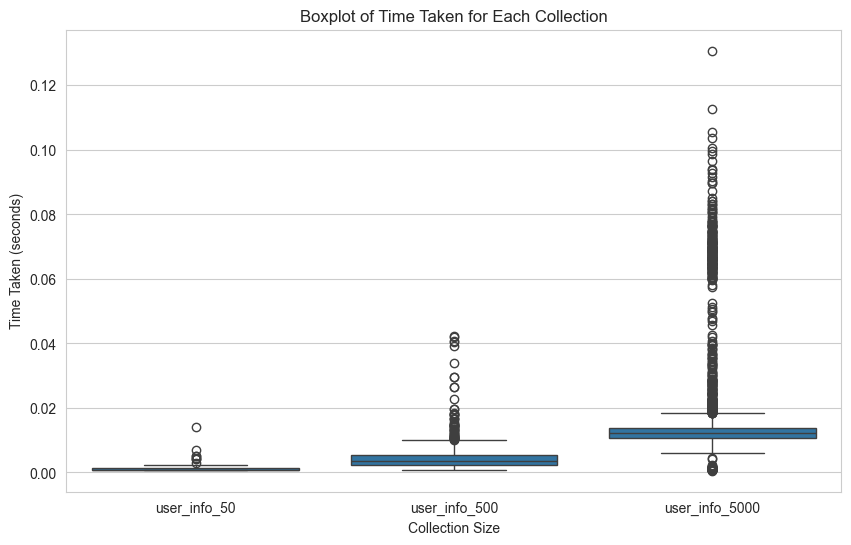

In [39]:
# Function to visualize the Boxplot of Time Taken
def plot_time_taken(times_50, times_500, times_5000):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=["user_info_50"] * len(times_50) + ["user_info_500"] * len(times_500) + ["user_info_5000"] * len(times_5000),
                y=times_50 + times_500 + times_5000)
    plt.xlabel("Collection Size")
    plt.ylabel("Time Taken (seconds)")
    plt.title("Boxplot of Time Taken for Each Collection")
    plt.show()

plot_time_taken(times_50, times_500, times_5000)


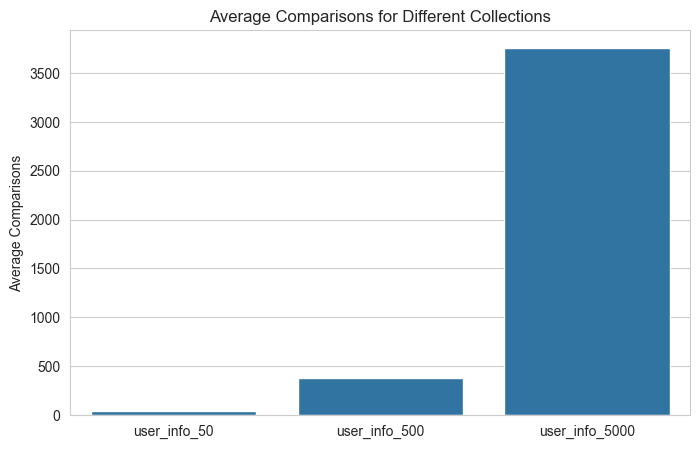

Average Comparisons for user_info_50: 37.75
Average Comparisons for user_info_500: 375.25
Average Comparisons for user_info_5000: 3750.25


In [40]:
# Function to visualize the Average Comparisons with Bar Plot
def plot_average_comparisons(comparisons_50, comparisons_500, comparisons_5000):
    avg_comparisons_50 = np.mean(comparisons_50)
    avg_comparisons_500 = np.mean(comparisons_500)
    avg_comparisons_5000 = np.mean(comparisons_5000)

    plt.figure(figsize=(8, 5))
    sns.barplot(x=["user_info_50", "user_info_500", "user_info_5000"], y=[avg_comparisons_50, avg_comparisons_500, avg_comparisons_5000])
    plt.ylabel("Average Comparisons")
    plt.title("Average Comparisons for Different Collections")
    plt.show()

    print(f"Average Comparisons for user_info_50: {avg_comparisons_50}")
    print(f"Average Comparisons for user_info_500: {avg_comparisons_500}")
    print(f"Average Comparisons for user_info_5000: {avg_comparisons_5000}")

# Plot Average Comparisons Bar Plot
plot_average_comparisons(comparisons_50, comparisons_500, comparisons_5000)


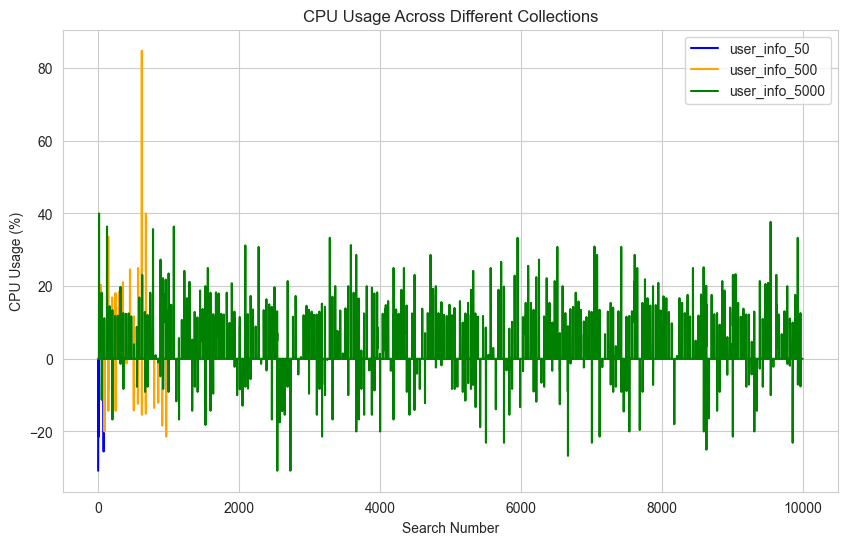

In [41]:
# Function to visualize CPU Usage with Line Plot
def plot_cpu_usage(cpu_usages_50, cpu_usages_500, cpu_usages_5000):
    plt.figure(figsize=(10, 6))
    plt.plot(cpu_usages_50, label="user_info_50", color="blue")
    plt.plot(cpu_usages_500, label="user_info_500", color="orange")
    plt.plot(cpu_usages_5000, label="user_info_5000", color="green")
    plt.xlabel("Search Number")
    plt.ylabel("CPU Usage (%)")
    plt.title("CPU Usage Across Different Collections")
    plt.legend()
    plt.show()

plot_cpu_usage(cpu_usages_50, cpu_usages_500, cpu_usages_5000)


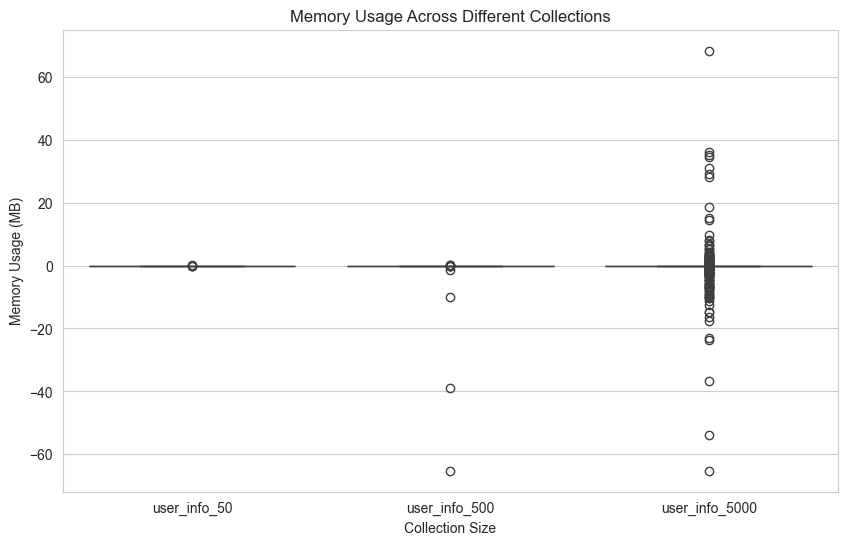

In [42]:
# Function to visualize Memory Usage with Box Plot
def plot_memory_usage(memory_usages_50, memory_usages_500, memory_usages_5000):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=["user_info_50"] * len(memory_usages_50) + ["user_info_500"] * len(memory_usages_500) + ["user_info_5000"] * len(memory_usages_5000),
                y=memory_usages_50 + memory_usages_500 + memory_usages_5000)
    plt.xlabel("Collection Size")
    plt.ylabel("Memory Usage (MB)")
    plt.title("Memory Usage Across Different Collections")
    plt.show()

plot_memory_usage(memory_usages_50, memory_usages_500, memory_usages_5000)


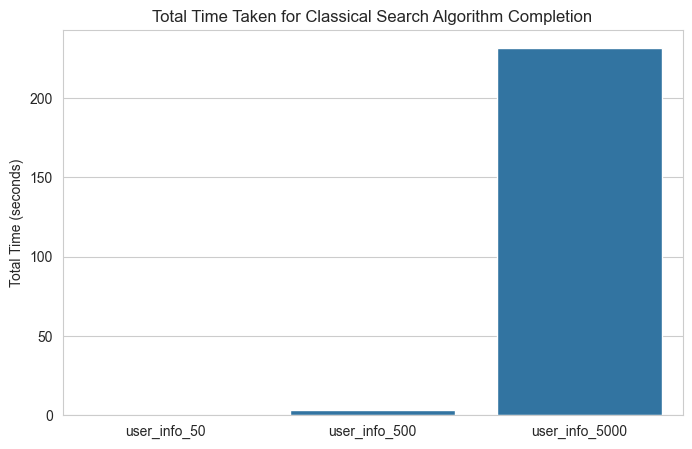

In [43]:
# Function to visualize Total Time Taken with Bar Plot
def plot_total_time(total_time_50, total_time_500, total_time_5000):
    total_times = [total_time_50, total_time_500, total_time_5000]
    collections = ['user_info_50', 'user_info_500', 'user_info_5000']

    plt.figure(figsize=(8, 5))
    sns.barplot(x=collections, y=total_times)
    plt.ylabel("Total Time (seconds)")
    plt.title("Total Time Taken for Classical Search Algorithm Completion")
    plt.show()

plot_total_time(total_time_50, total_time_500, total_time_5000)

In [44]:
# Function to print relevant statistics
def print_stats(collection_name):
    collection = db[collection_name]
    data = list(collection.find())
    df = pd.DataFrame(data)  # Convert data to DataFrame

    print(f"\nStatistics for {collection_name}:")

    # TimeTaken Stats
    mean_time = df['TimeTaken'].mean()
    median_time = df['TimeTaken'].median()
    std_dev_time = df['TimeTaken'].std()
    min_time = df['TimeTaken'].min()
    max_time = df['TimeTaken'].max()
    iqr_time = df['TimeTaken'].quantile(0.75) - df['TimeTaken'].quantile(0.25)

    print(f"Mean Time: {mean_time:.5f} s")
    print(f"Median Time: {median_time:.5f} s")
    print(f"Standard Deviation: {std_dev_time:.5f} s")
    print(f"Min Time: {min_time:.5f} s")
    print(f"Max Time: {max_time:.5f} s")
    print(f"IQR (Interquartile Range): {iqr_time:.5f} s")

    # Comparisons Stats
    mean_comparisons = df['Comparisons'].mean()
    median_comparisons = df['Comparisons'].median()
    std_dev_comparisons = df['Comparisons'].std()
    min_comparisons = df['Comparisons'].min()
    max_comparisons = df['Comparisons'].max()
    iqr_comparisons = df['Comparisons'].quantile(0.75) - df['Comparisons'].quantile(0.25)

    print(f"\nMean Comparisons: {mean_comparisons:.5f}")
    print(f"Median Comparisons: {median_comparisons:.5f}")
    print(f"Standard Deviation: {std_dev_comparisons:.5f}")
    print(f"Min Comparisons: {min_comparisons:.5f}")
    print(f"Max Comparisons: {max_comparisons:.5f}")
    print(f"IQR (Interquartile Range): {iqr_comparisons:.5f}")

    # Memory Usage Stats
    mean_memory_usage = df['MemoryUsage'].mean()
    median_memory_usage = df['MemoryUsage'].median()
    std_dev_memory_usage = df['MemoryUsage'].std()
    min_memory_usage = df['MemoryUsage'].min()
    max_memory_usage = df['MemoryUsage'].max()
    iqr_memory_usage = df['MemoryUsage'].quantile(0.75) - df['MemoryUsage'].quantile(0.25)

    print(f"\nMean Memory Usage: {mean_memory_usage:.5f} MB")
    print(f"Median Memory Usage: {median_memory_usage:.5f} MB")
    print(f"Standard Deviation: {std_dev_memory_usage:.5f} MB")
    print(f"Min Memory Usage: {min_memory_usage:.5f} MB")
    print(f"Max Memory Usage: {max_memory_usage:.5f} MB")
    print(f"IQR (Interquartile Range): {iqr_memory_usage:.5f} MB")

    # CPU Usage Stats
    mean_cpu_usage = df['CPUUsage'].mean()
    median_cpu_usage = df['CPUUsage'].median()
    std_dev_cpu_usage = df['CPUUsage'].std()
    min_cpu_usage = df['CPUUsage'].min()
    max_cpu_usage = df['CPUUsage'].max()
    iqr_cpu_usage = df['CPUUsage'].quantile(0.75) - df['CPUUsage'].quantile(0.25)

    print(f"\nMean CPU Usage: {mean_cpu_usage:.5f} %")
    print(f"Median CPU Usage: {median_cpu_usage:.5f} %")
    print(f"Standard Deviation: {std_dev_cpu_usage:.5f} %")
    print(f"Min CPU Usage: {min_cpu_usage:.5f} %")
    print(f"Max CPU Usage: {max_cpu_usage:.5f} %")
    print(f"IQR (Interquartile Range): {iqr_cpu_usage:.5f} %")

# Print stats for each collection
print_stats('classical_search_50')
print_stats('classical_search_500')
print_stats('classical_search_5000')



Statistics for classical_search_50:
Mean Time: 0.00145 s
Median Time: 0.00090 s
Standard Deviation: 0.00166 s
Min Time: 0.00062 s
Max Time: 0.01408 s
IQR (Interquartile Range): 0.00064 s

Mean Comparisons: 37.75000
Median Comparisons: 50.00000
Standard Deviation: 16.02358
Min Comparisons: 1.00000
Max Comparisons: 50.00000
IQR (Interquartile Range): 24.25000

Mean Memory Usage: -0.00016 MB
Median Memory Usage: 0.00000 MB
Standard Deviation: 0.02908 MB
Min Memory Usage: -0.20312 MB
Max Memory Usage: 0.20312 MB
IQR (Interquartile Range): 0.00000 MB

Mean CPU Usage: -1.06400 %
Median CPU Usage: 0.00000 %
Standard Deviation: 4.90838 %
Min CPU Usage: -30.80000 %
Max CPU Usage: 0.00000 %
IQR (Interquartile Range): 0.00000 %

Statistics for classical_search_500:
Mean Time: 0.00465 s
Median Time: 0.00347 s
Standard Deviation: 0.00427 s
Min Time: 0.00066 s
Max Time: 0.04222 s
IQR (Interquartile Range): 0.00303 s

Mean Comparisons: 375.25000
Median Comparisons: 500.00000
Standard Deviation: 161.

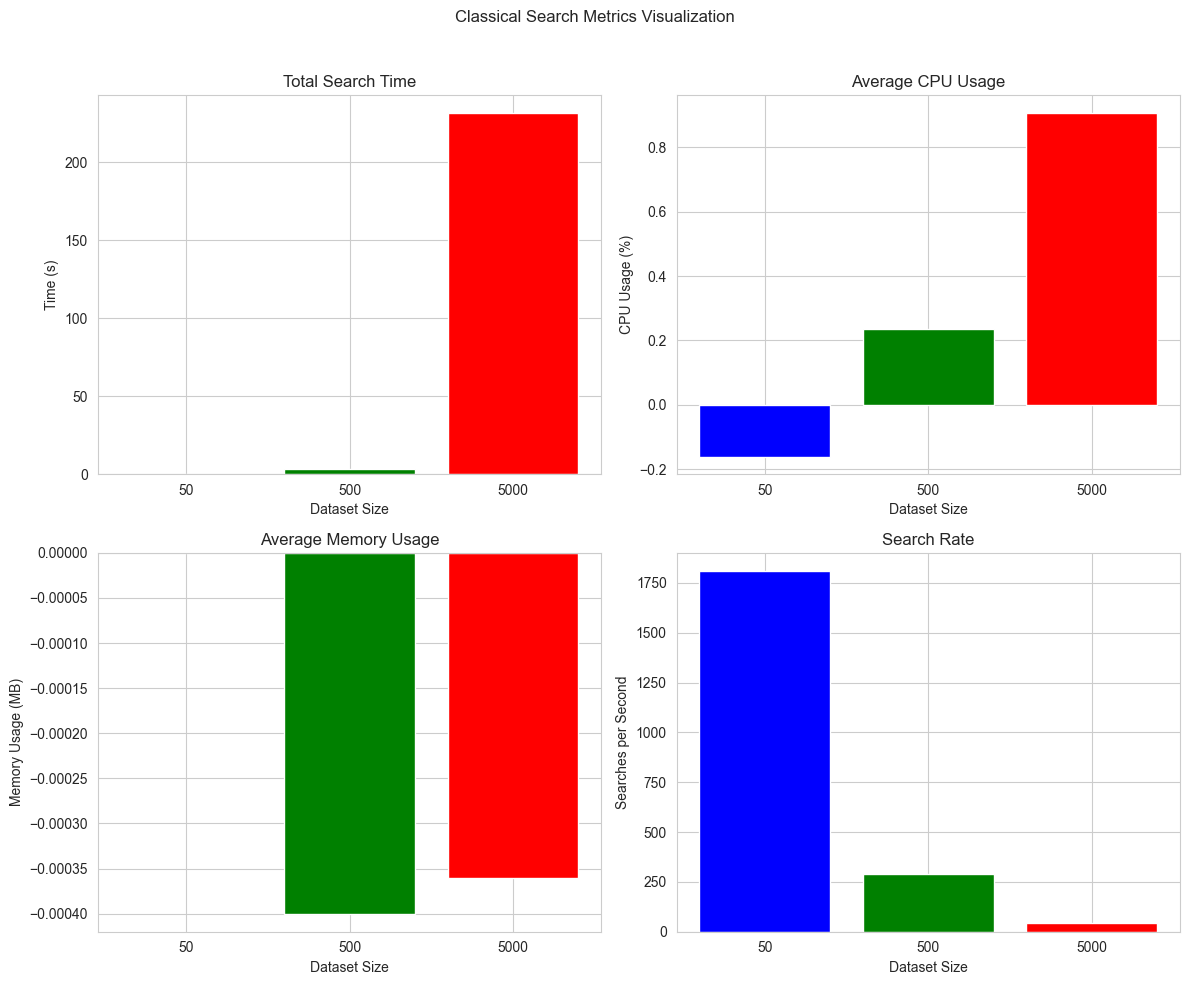

In [45]:
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
dataset_sizes = ['50', '500', '5000']
total_times = [total_time_50, total_time_500, total_time_5000]
avg_cpu_usages = [avg_cpu_50, avg_cpu_500, avg_cpu_5000]
avg_memory_usages = [avg_memory_50, avg_memory_500, avg_memory_5000]
search_rates = [searches_per_sec_50, searches_per_sec_500, searches_per_sec_5000]

# Set up figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Classical Search Metrics Visualization')

# Total Time Bar Chart
axes[0, 0].bar(dataset_sizes, total_times, color=['blue', 'green', 'red'])
axes[0, 0].set_title('Total Search Time')
axes[0, 0].set_ylabel('Time (s)')
axes[0, 0].set_xlabel('Dataset Size')

# Average CPU Usage Bar Chart
axes[0, 1].bar(dataset_sizes, avg_cpu_usages, color=['blue', 'green', 'red'])
axes[0, 1].set_title('Average CPU Usage')
axes[0, 1].set_ylabel('CPU Usage (%)')
axes[0, 1].set_xlabel('Dataset Size')

# Average Memory Usage Bar Chart
axes[1, 0].bar(dataset_sizes, avg_memory_usages, color=['blue', 'green', 'red'])
axes[1, 0].set_title('Average Memory Usage')
axes[1, 0].set_ylabel('Memory Usage (MB)')
axes[1, 0].set_xlabel('Dataset Size')

# Search Rate (Searches per second)
axes[1, 1].bar(dataset_sizes, search_rates, color=['blue', 'green', 'red'])
axes[1, 1].set_title('Search Rate')
axes[1, 1].set_ylabel('Searches per Second')
axes[1, 1].set_xlabel('Dataset Size')

# Improve layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
